## Module operating temperature model parameter determination

Notebook author: Anton Driesse <anton.driesse@pvperformancelabs.com>


Last modified: 2022-12-30

This notebook provides examples and guidance for determining the parameters for PV module operating temperature models using field measurements. 
The Faiman model is used as an example, but the techniques shown here are directly applicable to all four commonly-used linear steady-state models: Faiman, SAPM, PVsyst and SAM-NOCT. 

(We refer to these models as "linear" because the temperature increase above ambient varies linearly with the dominant input variable irradiance.  The placement of the windspeed variable makes the model equations non-linear in the mathematical sense.)

The three main aspects addressed are:
1. the choice of error metric for the fitting process
2. dealing with dynamic conditions
3. incorporating a new radiative loss term

The radiative loss term is explained in this recently published report:

- Driesse, A. et al (2022) "Improving Common PV Module Temperature
Models by Incorporating Radiative Losses to the Sky". SAND2022-11604.
[doi:10.2172/1884890](https://dx.doi.org/10.2172/1884890)


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib

# optional preferences
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['figure.figsize'] = (8, 4)

# this line enables interactive graphics, but
# if you don's see any graphs, try removing it
# %matplotlib notebook


In [2]:
from pvlib.temperature import faiman


In [3]:
# define some plotting functions to reduce clutter in the script

def temperature_plot(measured, modelled, ambient=None):

    err = measured - modelled
    mbe = np.mean(err)
    rmse = np.sqrt(np.mean(np.square(err)))

    plt.figure()

    if ambient is None:
        plt.xlabel('Tmod measured [°C]')
        plt.ylabel('Tmod modelled [°C]')
    else:
        measured = measured - ambient
        modelled = modelled - ambient
        
        plt.xlabel('Tmod − Tamb, measured [°C]')
        plt.ylabel('Tmod − Tamb, modelled [°C]')

    plt.plot(measured, modelled, '.', color='grey')
    plt.plot(measured, modelled, '.', color='r', alpha=.01)
    
    plt.xlim(-20, 70); plt.ylim(-20, 70);
    plt.plot([-20, 70], [-20, 70], 'k-', alpha=0.5)
    
    ax = plt.gca()
    plt.text(.5, .90, f'MBE={mbe:.1f}, RMSE={rmse:.1f}', 
             ha='center', transform=ax.transAxes)
    return ax

def heat_transfer_plot(ws, u):

    plt.figure()
    
    plt.plot(ws, u, '.', color='grey')
    plt.plot(ws, u, '.', color='b', alpha=.02)
    
    plt.xlim(0, 12.5)
    plt.ylim(-10, 110)
    
    plt.ylabel('U = Gpoa / (Tmod − Tamb) [W/m²/K]')
    plt.xlabel('Windspeed [m/s]')
    
    return plt.gca()

def dict2str(popt_dict):
    return ', '.join([f'{k}={v:.2f}' for k, v in popt_dict.items()])


In [4]:
# read the open data set (documentation is available separately)

NC = 'nc/tmod_sample_data.nc'

with xr.open_dataset(NC) as ds:
    ds.load()

# uncomment this line to run the script for a period with very clear days
# ds = ds.sel(time=slice('2020-10-03','2020-10-23'))

# comment this line to keep night-time data in all fits and graphs
ds = ds.where(ds.poa_global > 10)

print(ds)


<xarray.Dataset>
Dimensions:     (time: 527041, position: 4)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2021-01-01
  * position    (position) int64 1 2 3 4
Data variables:
    poa_global  (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    wind_speed  (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    temp_air    (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    temp_pv     (time, position) float32 nan nan nan nan nan ... nan nan nan nan
    ir_down     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    tilt:        35.0
    orient:      180.0
    latitude:    35.0545
    longitude:   -106.54
    altitude:    1660
    timezone:    -7
    source:      Sandia Labs
    processing:  PV Performance Labs
    comment:     


In [5]:
print(ds.temp_pv)


<xarray.DataArray 'temp_pv' (time: 527041, position: 4)>
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-01 ... 2021-01-01
  * position  (position) int64 1 2 3 4
Attributes:
    model:       Panasonic HIT
    technology:  mono
    ncells:      96
    p_stc:       325
    gamma_p:     -0.0042
    area:        1.67427
    eta_stc:     0.19411444987964904
    backsheet:   polymer (white)
    bifi:        0
    comment:     
    precision:   3


In [6]:
# PV temperature sensor locations 1 and 4 are on the upper row of modules
# least affected by row shading--use their average for fitting

ds['temp_pv'] = ds.temp_pv.loc[:, [1,4]].mean('position')
ds = ds.drop_dims(['position'])


In [7]:
# convert to a dataframe

df = ds.to_dataframe()

print(df.dropna())


                     poa_global  wind_speed  temp_air   temp_pv     ir_down
time                                                                       
2020-01-01 07:28:00   10.481445    1.868164 -3.394531 -9.181152  197.674805
2020-01-01 07:29:00   11.011719    1.955078 -3.426758 -9.177246  197.712891
2020-01-01 07:30:00   11.545898    1.743164 -3.464844 -9.191406  197.751953
2020-01-01 07:31:00   12.043945    1.309570 -3.468750 -9.204102  197.791992
2020-01-01 07:32:00   12.546875    1.282227 -3.482422 -9.187988  197.833984
...                         ...         ...       ...       ...         ...
2020-12-31 16:50:00  110.105469    2.221680  7.797852  4.516113  213.302734
2020-12-31 16:51:00  102.231445    1.948242  7.782227  4.101562  213.268555
2020-12-31 16:52:00   91.292969    2.126953  7.791992  3.754883  213.235352
2020-12-31 16:53:00   66.541992    2.160156  7.908203  3.407227  213.200195
2020-12-31 16:54:00   30.107422    2.347656  7.905273  3.005859  213.165039

[249587 row

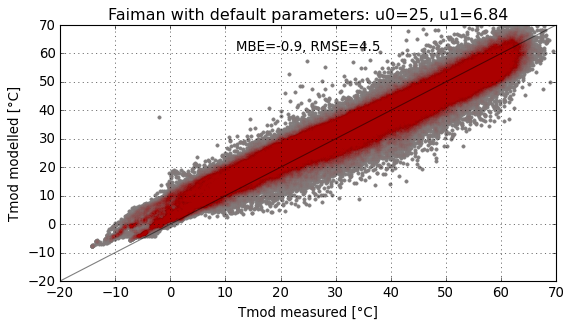

In [8]:
# see how the model does using the default parameters

modelled = faiman(df.poa_global, df.temp_air, df.wind_speed)
temperature_plot(df.temp_pv, modelled)
plt.title('Faiman with default parameters: u0=25, u1=6.84');


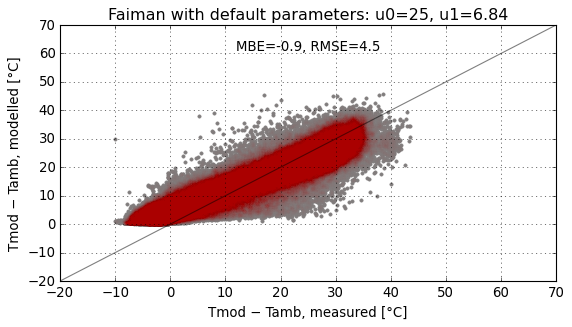

In [9]:
# subtracting the ambient temperature from module temperature
# shows the model limitations more clearly

temperature_plot(df.temp_pv, modelled, df.temp_air)
plt.title('Faiman with default parameters: u0=25, u1=6.84');


In [10]:
# hopefully fitting will improve on this!

---
### 1. Choice of error metric

The "best" fit is the one that leads to the smallest model errors, but this metric can be defined in different ways.

#### 1.1 Mean squared error in $U$

One approach to finding the model parameters is 
to rearrange the model equation as an implicit function:

${\displaystyle u_0 + u_1 \times WS = \frac{G_{poa}}{T_{mod} - T_{amb}}}$

The **RHS** of this equation is the observed heat transfer coefficient $U$,
and the **LHS** is a simple linear function of wind speed ($WS$).
The coefficients of this linear function, $u_0$ and $u_1$ can be found by linear regression,
which minimizes the mean squared error of the predicted $U$ values.  In other words, the error metric is the mean squared error in $U$.


In [11]:
# start with a fresh copy of the data and add the u values

dfu = df.eval('u = poa_global / (temp_pv - temp_air)')

# drop any infinite or invalid values
dfu = dfu.where(np.isfinite(dfu.u))
dfu = dfu.dropna()


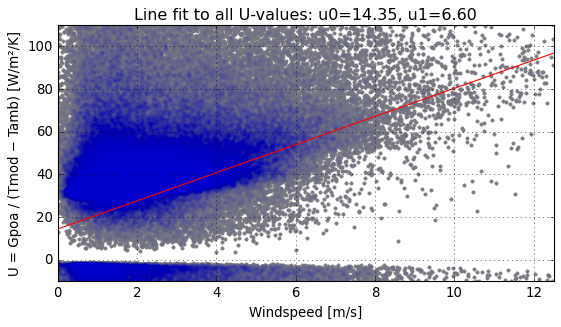

In [12]:
# now fit a line (first-degree polynomial)

df2 = dfu

popt = np.polyfit(df2.wind_speed, df2.u, deg=1)

heat_transfer_plot(df2.wind_speed, df2.u);
plt.plot([0, 15], np.polyval(popt, [0, 15]), 'r-')

popt = dict(zip(('u0', 'u1'), popt[::-1]))
plt.title('Line fit to all U-values: ' + dict2str(popt));


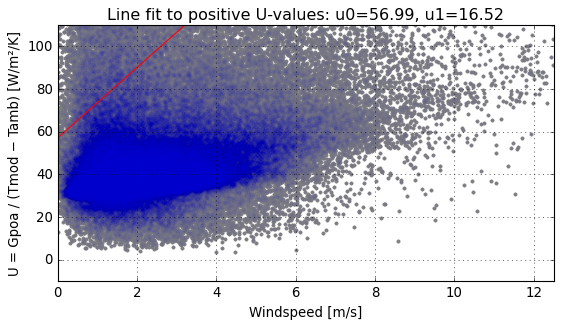

In [13]:
# unfortunately real data also have module temperatures below ambient
# which leads to non-physical negative u-values
# better to drop them and try again

df2 = dfu.where(dfu.u > 0)
df2 = df2.dropna()

heat_transfer_plot(df2.wind_speed, df2.u)

popt = np.polyfit(df2.wind_speed, df2.u, deg=1)
plt.plot([0, 15], np.polyval(popt, [0, 15]), 'r-')

popt = dict(zip(('u0', 'u1'), popt[::-1]))
plt.title('Line fit to positive U-values: ' + dict2str(popt));


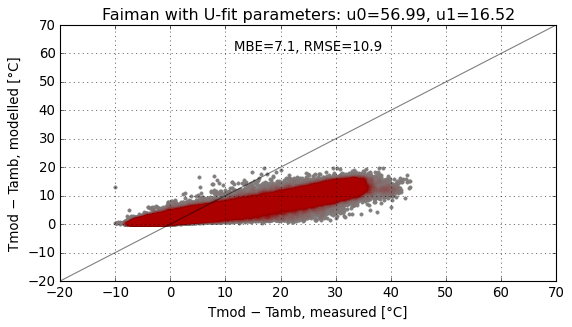

In [14]:
# check whether this makes good temperature predictions

modelled = faiman(df.poa_global, df.temp_air, df.wind_speed, **popt)
temperature_plot(df.temp_pv, modelled, df.temp_air)
plt.title('Faiman with U-fit parameters: ' + dict2str(popt));


In [15]:
# clearly this is not producing great parameters
# the usual technique to deal with this is to reject data points
# that could throw the solution off, for example low irradiance conditions

# as shown next, the parameters found depend a lot on the choice of rejection threshold

df2 = dfu.where(dfu.u > 0)

for threshold in range(0, 900, 100):

    df2 = df2.where(df2.poa_global > threshold).dropna()
    popt = np.polyfit(df2.wind_speed, df2.u, deg=1).round(2)
    print('Gpoa > %3d %s %6d data points' % (threshold, str(popt[::-1]), len(df2)))

print()

df2 = dfu.where(dfu.u > 0)

for threshold in range(0, 25+1, 5):

    df2 = df2.where(df2.temp_pv - df2.temp_air > threshold).dropna()
    popt = np.polyfit(df2.wind_speed, df2.u, deg=1).round(2)
    print('Trise > %2d %s %6d data points' % (threshold, str(popt[::-1]), len(df2)))


Gpoa >   0 [56.99 16.52] 199008 data points
Gpoa > 100 [55.43 14.99] 196519 data points
Gpoa > 200 [55.78  6.5 ] 184947 data points
Gpoa > 300 [35.7   5.62] 167919 data points
Gpoa > 400 [30.8   4.91] 150287 data points
Gpoa > 500 [29.2   4.72] 134139 data points
Gpoa > 600 [28.42  4.56] 118358 data points
Gpoa > 700 [28.21  4.35] 101719 data points
Gpoa > 800 [27.91  4.26]  83532 data points

Trise >  0 [56.99 16.52] 199008 data points
Trise >  5 [31.74  3.82] 166823 data points
Trise > 10 [30.23  3.41] 139784 data points
Trise > 15 [29.8   3.03] 114744 data points
Trise > 20 [30.32  2.27]  87226 data points
Trise > 25 [30.67  1.59]  55611 data points


#### 1.2 Weighted mean squared error in $U$

The best fit line obtained above minimizes sum of the squares of the errors in $U$-values.
The $U$-values are only indirectly related to module temperature, 
therefore this does not necessarily lead to the best temperature predictions.

A big improvement can be made by using a weighted least-squares fit, where the weight for each data point is calculated as:

${\displaystyle w_i = \sqrt{\frac {T_{mod}-T_{amb}}{U}}}$

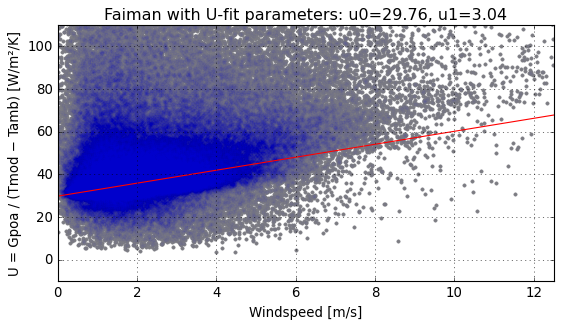

In [16]:
# use weighted least-squares fit

dfw = dfu.where(dfu.u > 0)
dfw = dfw.eval('weight = sqrt((temp_pv - temp_air) / u)')
dfw = dfw.where(np.isfinite(dfw.weight))
dfw = dfw.dropna()

df2 = dfw

popt = np.polyfit(df2.wind_speed, df2.u, deg=1, w=df2.weight).round(3)
heat_transfer_plot(df2.wind_speed, df2.u)

plt.plot([0, 12.5], np.polyval(popt, [0, 12.5]), 'r-')
popt = dict(zip(('u0', 'u1'), popt[::-1]))
plt.title('Faiman with U-fit parameters: ' + dict2str(popt));


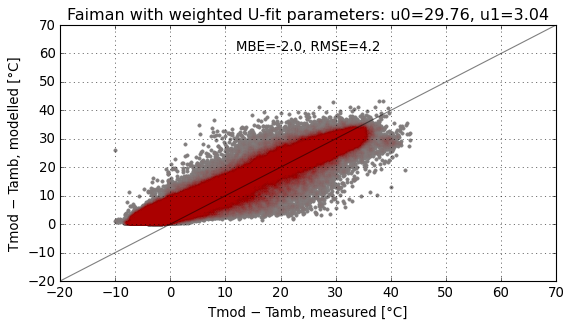

In [17]:
modelled = faiman(df.poa_global, df.temp_air, df.wind_speed, **popt)
temperature_plot(df.temp_pv, modelled, df.temp_air)
plt.title('Faiman with weighted U-fit parameters: ' + dict2str(popt));


In [18]:
# using the weights, the result is much less sensitive to the rejection thresholds

df2 = dfw

for threshold in range(0, 900, 100):

    df2 = df2.where(df2.poa_global > threshold).dropna()
    popt = np.polyfit(df2.wind_speed, df2.u, deg=1, w=df2.weight).round(2)
    print('Gpoa > %3d %s %6d data points' % (threshold, str(popt[::-1]), len(df2)))

print()

df2 = dfw

for threshold in range(0, 25+1, 5):

    df2 = df2.where(df2.temp_pv - df2.temp_air > threshold).dropna()
    popt = np.polyfit(df2.wind_speed, df2.u, deg=1, w=df2.weight).round(2)
    print('Trise > %2d %s %6d data points' % (threshold, str(popt[::-1]), len(df2)))


Gpoa >   0 [29.76  3.04] 199008 data points
Gpoa > 100 [29.75  3.06] 196519 data points
Gpoa > 200 [29.77  3.12] 184947 data points
Gpoa > 300 [29.74  3.18] 167919 data points
Gpoa > 400 [29.6   3.23] 150287 data points
Gpoa > 500 [29.37  3.26] 134139 data points
Gpoa > 600 [29.14  3.27] 118358 data points
Gpoa > 700 [28.97  3.24] 101719 data points
Gpoa > 800 [28.78  3.24]  83532 data points

Trise >  0 [29.76  3.04] 199008 data points
Trise >  5 [29.79  2.84] 166823 data points
Trise > 10 [29.61  2.68] 139784 data points
Trise > 15 [29.59  2.47] 114744 data points
Trise > 20 [29.98  2.01]  87226 data points
Trise > 25 [30.24  1.55]  55611 data points


#### 1.3 Mean squared error in $T_{mod}$

Although the weighted errors in $U$ lead to smaller errors in temperature predictions,
a true minimization of the temperature errors is also easily done
using a non-linear numerical optimization of the original model equation.

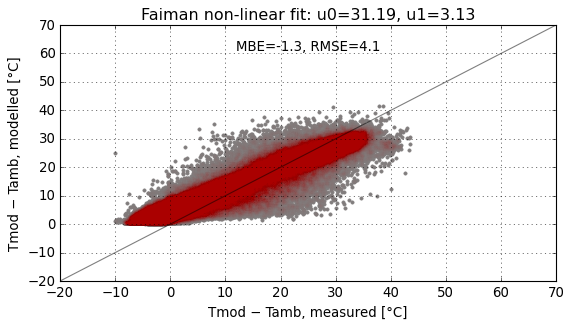

In [19]:

df2 = dfu.dropna()

# make a wrapper for the model function so it can be called by curve_fit

def fitfun(xdata, *params):
    return faiman(*xdata, *params)

# prepare the data in the form needed by curve_fit
xdata = [df2[c] for c in['poa_global','temp_air','wind_speed']]
ydata = df2['temp_pv']

# make a first guess what the parameters might be
p0 = [10, 1]

popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

popt = dict(zip(('u0', 'u1'), popt))

# comparison plot
tmod_model = faiman(df.poa_global, df.temp_air, df.wind_speed, **popt)
temperature_plot(df.temp_pv, tmod_model, df.temp_air)
plt.title('Faiman non-linear fit: ' + dict2str(popt));


### 2 Dealing with dynamic conditions

Under rapidly-changing conditions the steady-state models have very large errors,
which makes parameter extraction more difficult.
One approach to dealing with this is to use only steady-state conditions for fitting.
This is reasonable in principle, but truly steady-state conditions are rare
and the parameters found in this way may depend on the criteria used
to separate steady-state from dynamic conditions.

Fortunately there is a better way.  The thermal mass of the module delays and reduces
fluctuations in module temperature compared to a module without thermal mass.
When the *inputs* to the steady-state temperature model are preprocessed
to delay and smooth their fluctuations, the model output follows the measured temperature much more closely.
A simple moving average over 25 minutes accomplishes this objective nicely for typical glass-polymer modules.


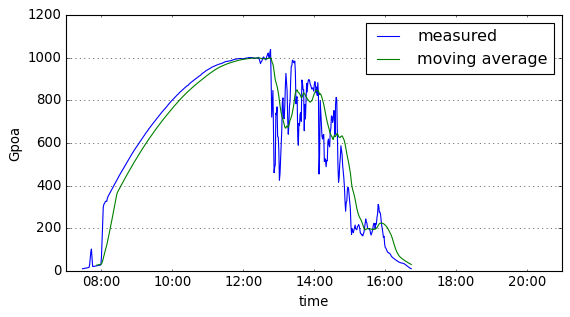

In [20]:
# calculate a moving average for the three model input parameters

WINDOW = 25 

dfm = df.copy()
for c in ['poa_global', 'wind_speed', 'temp_air']:
    dfm[c] = dfm[c].rolling(WINDOW, center=False).mean()

dfm = dfm.eval('u = poa_global / (temp_pv - temp_air)')

plt.figure()
df.poa_global[7*60:21*60].plot()
dfm.poa_global[7*60:21*60].plot()
plt.ylabel('Gpoa')
plt.legend(['measured', 'moving average'])

dfm = dfm.dropna()
    

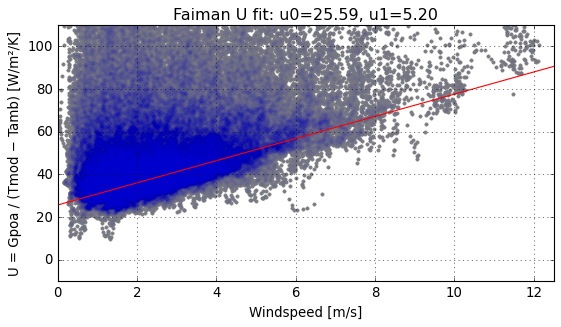

In [21]:
# show the effect on U fitting

df2 = dfm.copy()
df2 = df2[np.isfinite(df2.u)]
df2 = df2[df2.u > 0]

weights = np.sqrt((df2.temp_pv - df2.temp_air) / df2.u)
popt = np.polyfit(df2.wind_speed, df2.u, deg=1, w=weights).round(3)
heat_transfer_plot(df2.wind_speed, df2.u)

plt.plot([0, 12.5], np.polyval(popt, [0, 12.5]), 'r-')
popt = dict(zip(('u0', 'u1'), popt[::-1]))
plt.title('Faiman U fit: ' + dict2str(popt));


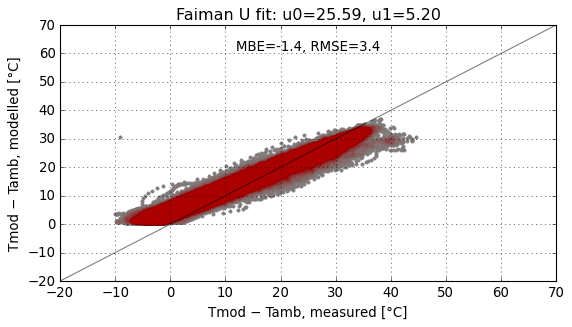

In [22]:
# comparison plot
tmod_model = faiman(dfm.poa_global, dfm.temp_air, dfm.wind_speed, **popt)

temperature_plot(dfm.temp_pv, tmod_model, dfm.temp_air)
plt.title('Faiman U fit: ' + dict2str(popt));


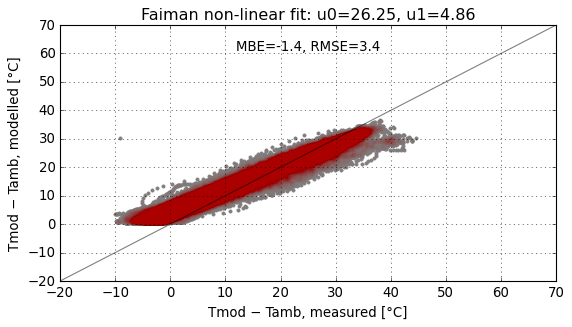

In [23]:
def fitfun(xdata, *params):
    return faiman(*xdata, *params)

# prepare the data
df2 = dfm.copy()
df2 = df2.where(dfm.u > 0).dropna()

xdata = [df2[c] for c in['poa_global','temp_air','wind_speed']]
ydata = df2['temp_pv']
p0 = [10, 1]

popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

popt = dict(zip(('u0', 'u1'), popt))

# comparison plot
tmod_model = faiman(dfm.poa_global, dfm.temp_air, dfm.wind_speed, **popt)

temperature_plot(dfm.temp_pv, tmod_model, dfm.temp_air)
plt.title('Faiman non-linear fit: ' + dict2str(popt));

# remember these values for later
popt_best_before_rad = popt

### 3 Accounting for radiative losses to the sky

One of the weaknesses of the linear models such as Faiman is 
that they lump radiative losses and convective losses together,
making them all proportional to the temperature difference between
module and ambient temperature.
This is not a bad approximation for radiative losses toward the ground and surrounding objects
which are likely near ambient temperature, but the effective sky temperature
is usually well below ambient.
The following section uses a new module temperature model that adds
a radiative loss term to the Faiman model.
The development of this model is explained in:

- Driesse, A. et al (2022) "Improving Common PV Module Temperature
Models by Incorporating Radiative Losses to the Sky". SAND2022-11604.
[doi:10.2172/1884890](https://dx.doi.org/10.2172/1884890)


In [24]:
# recalculate a moving average for the input variables, including ir_down this time

dfm = df.copy()
for c in ['poa_global', 'wind_speed', 'temp_air', 'ir_down']:
    dfm[c] = dfm[c].rolling(25, center=False).mean()

dfm = dfm.dropna()


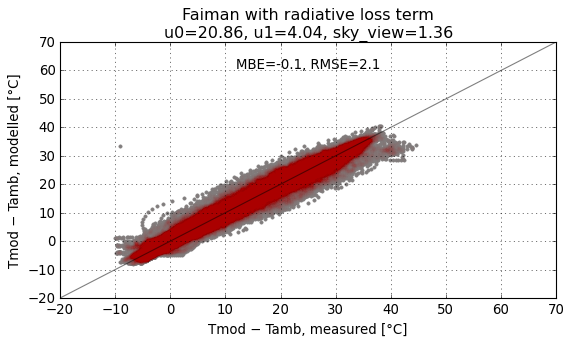

In [25]:
# fit the new model to all the data

# import and wrap the new model function
from pvlib.temperature import faiman_rad

def fitfun(xdata, *params):
    return faiman_rad(*xdata, *params)

# prepare the data
xdata = [dfm[c] for c in['poa_global','temp_air','wind_speed', 'ir_down']]
ydata = dfm['temp_pv']
# note there are three fitting parameters now
p0 = [10, 1, 1]

popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

popt = dict(zip(('u0', 'u1', 'sky_view'), popt.round(3)))

# comparison plot
tmod_model = faiman_rad(dfm.poa_global, dfm.temp_air, dfm.wind_speed, dfm.ir_down, **popt)

temperature_plot(dfm.temp_pv, tmod_model, dfm.temp_air)
plt.title('Faiman with radiative loss term\n' + dict2str(popt));


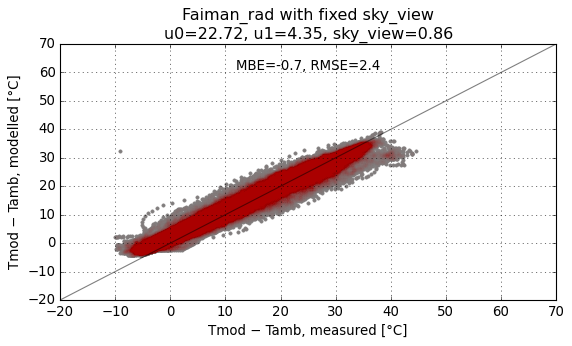

In [26]:
# it is possible to obtain a the best fits by allowing the sky_view factor to vary
# but this can lead to unrealistic view factor values as seen above
# based on the definition, sky_view cannot be larger than 1
# the view factor parameter is best set manually based on knowledge of the pv system
# such as the tilt angle, as discussed in the reference

SKY_VIEW = 0.865 # value estimated for 35 deg tilt

def fitfun(xdata, *params):
    return faiman_rad(*xdata, *params, sky_view=SKY_VIEW)

# prepare the data
df2 = dfm
xdata = [df2[c] for c in['poa_global','temp_air','wind_speed', 'ir_down']]
ydata = df2['temp_pv']
# back to two fitting parameters
p0 = [10, 1]

popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

popt = dict(zip(('u0', 'u1'), popt.round(3)))
popt['sky_view'] = SKY_VIEW

# comparison plot
tmod_model = faiman_rad(dfm.poa_global, dfm.temp_air, dfm.wind_speed, dfm.ir_down, **popt)

temperature_plot(dfm.temp_pv, tmod_model, dfm.temp_air)
plt.title('Faiman_rad with fixed sky_view\n' + dict2str(popt));


In [27]:
# plot a day

tmod_model = faiman_rad(dfm.poa_global, dfm.temp_air, dfm.wind_speed, dfm.ir_down, **popt)
faiman_best_before_rad = faiman(df.poa_global, df.temp_air, df.wind_speed,
                                **popt_best_before_rad)
faiman_best_before_rad.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:01:00',
               '2020-01-01 00:02:00', '2020-01-01 00:03:00',
               '2020-01-01 00:04:00', '2020-01-01 00:05:00',
               '2020-01-01 00:06:00', '2020-01-01 00:07:00',
               '2020-01-01 00:08:00', '2020-01-01 00:09:00',
               ...
               '2020-12-31 23:51:00', '2020-12-31 23:52:00',
               '2020-12-31 23:53:00', '2020-12-31 23:54:00',
               '2020-12-31 23:55:00', '2020-12-31 23:56:00',
               '2020-12-31 23:57:00', '2020-12-31 23:58:00',
               '2020-12-31 23:59:00', '2021-01-01 00:00:00'],
              dtype='datetime64[ns]', name='time', length=527041, freq=None)

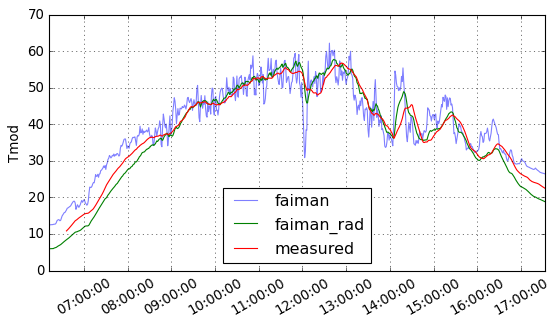

In [28]:
one_day = slice('2020-10-02','2020-10-02')

plt.figure()
plt.plot(faiman_best_before_rad.loc[one_day], alpha=.5)
plt.plot(df.temp_pv.loc[one_day])
plt.plot(tmod_model.loc[one_day])
plt.xticks(rotation=30)
plt.ylabel('Tmod')
plt.legend(['faiman', 'faiman_rad', 'measured'], loc='best');

In [29]:
# check sensitivity to selection criteria again

for threshold in range(0, 800+1, 100):

    df2 = dfm.where(dfm.poa_global > threshold).dropna()
    xdata = [df2[c] for c in['poa_global','temp_air','wind_speed', 'ir_down']]
    ydata = df2['temp_pv']
    p0 = [10, 1]

    popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

    popt = dict(zip(('u0', 'u1', 'sky_view'), popt.round(3)))
    print('Gpoa > %3d %s %6d data points' % (threshold, dict2str(popt), len(df2)))

print()

for threshold in range(0, 25+1, 5):

    df2 = dfm.where(dfm.temp_pv - dfm.temp_air > threshold).dropna()
    xdata = [df2[c] for c in['poa_global','temp_air','wind_speed', 'ir_down']]
    ydata = df2['temp_pv']
    p0 = [10, 1]

    popt, pcov = curve_fit(fitfun, xdata, ydata, p0)

    popt = dict(zip(('u0', 'u1', 'sky_view'), popt.round(3)))
    #popt['sky_view'] = SKY_VIEW
    print('Trise > %2d %s %6d data points' % (threshold, dict2str(popt), len(df2)))


Gpoa >   0 u0=22.72, u1=4.35 240539 data points
Gpoa > 100 u0=22.75, u1=4.35 212549 data points
Gpoa > 200 u0=22.73, u1=4.35 190232 data points
Gpoa > 300 u0=22.66, u1=4.35 170408 data points
Gpoa > 400 u0=22.56, u1=4.36 152381 data points
Gpoa > 500 u0=22.42, u1=4.37 135517 data points
Gpoa > 600 u0=22.29, u1=4.38 118923 data points
Gpoa > 700 u0=22.24, u1=4.36 101258 data points
Gpoa > 800 u0=22.18, u1=4.34  81689 data points

Trise >  0 u0=22.75, u1=4.34 199726 data points
Trise >  5 u0=22.77, u1=4.25 167594 data points
Trise > 10 u0=22.79, u1=4.15 140748 data points
Trise > 15 u0=22.89, u1=3.98 115603 data points
Trise > 20 u0=23.37, u1=3.58  88488 data points
Trise > 25 u0=23.84, u1=3.16  57273 data points


Month  1 u0=20.33, u1=5.75  11499 data points
Month  2 u0=21.45, u1=5.44  17230 data points
Month  3 u0=21.68, u1=4.88  20599 data points
Month  4 u0=21.57, u1=4.66  21994 data points
Month  5 u0=21.99, u1=3.83  24258 data points
Month  6 u0=22.71, u1=3.72  23581 data points
Month  7 u0=23.37, u1=3.91  24302 data points
Month  8 u0=24.06, u1=3.55  22794 data points
Month  9 u0=22.61, u1=4.68  20686 data points
Month 10 u0=23.13, u1=4.24  19483 data points
Month 11 u0=21.95, u1=5.23  17252 data points
Month 12 u0=21.70, u1=6.24  16861 data points


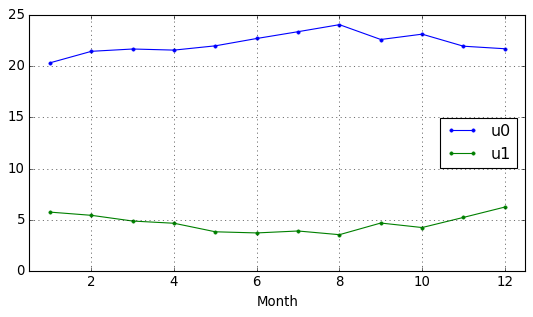

In [30]:
# now determine the parameters separately for each calendar month

results = []
for month in range(1, 12+1):

    df2 = dfm.loc[dfm.index.month.values == month]
    xdata = [df2[c] for c in['poa_global','temp_air','wind_speed', 'ir_down']]
    ydata = df2['temp_pv']
    p0 = [10, 1]

    popt, pcov = curve_fit(fitfun, xdata, ydata, p0)
    results.append(popt)

    popt = dict(zip(('u0', 'u1', 'sky_view'), popt.round(3)))
    print('Month %2d %s %6d data points' % (month, dict2str(popt), len(df2)))
    
plt.figure()
#plt.plot(zip(results))
plt.plot(range(1, 12+1), np.array(results), '.-')
plt.xlim(0.5, 12.5)
plt.xlabel('Month')
plt.legend(['u0', 'u1'], loc='best');


### Conclusions

We have shown that model predictions improve progressively when

1. the appropriate error metric is used, 
2. dynamic conditions are compensated for, and
3. radiative losses to the sky are represented separately.

The differences between modelled and measured temperature are substantially reduced 
and the parameters are much less influenced by data selection/rejection criteria.
Neverthless, these linear models remains a simplification of reality as evidenced by the seasonal variation of parameters in the last example.

The big challenge is to estimate model parameters for future systems
taking into account varying PV module properties, mounting system details and location-specific climate factors.
Empirical data collected while pursuing this larger objective can be analyzed using the modelling and fitting techniques explored in this notebook.

<font size=1>Sandia National Laboratories is a multi-mission laboratory managed and operated by National Technology & Engineering Solutions of Sandia, LLC, a wholly owned subsidiary of Honeywell International Inc., for the U.S. Department of Energy’s National Nuclear Security Administration under contract DE-NA0003525.</font>